In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config IPCompleter.greedy=True

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'Color Incorrect'),
  Text(1.5, 0, 'Diameter'),
  Text(2.5, 0, 'Dimensional'),
  Text(3.5, 0, 'Laser Mark Incorrect'),
  Text(4.5, 0, 'Other'),
  Text(5.5, 0, 'Scratches'),
  Text(6.5, 0, 'Surface Finish'),
  Text(7.5, 0, 'Tools Marks / Chatte')])

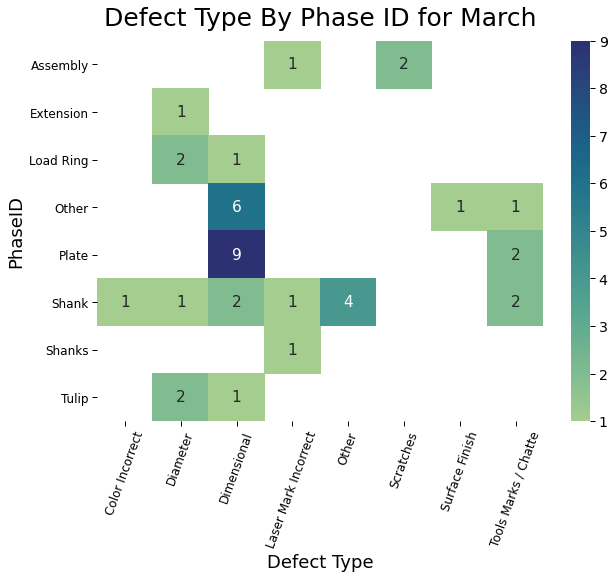

In [2]:
dept_names = pd.read_csv('csv\JCDept.csv',names=['Origin_ref','Origin'])
NC_df = pd.read_csv('csv\PT_NC.csv', header=0)
# dept_names['Origin_ref'] = dept_names['Origin_ref'].astype('object')

NC_df = NC_df.merge(dept_names, how='left', on='Origin_ref')
NC_df['NCR_Date'] = NC_df['NCR_Date'].astype('datetime64')

# Grab results from the current month
df_filtered = NC_df['NCR_Date'] > '03/01/2021'
NC_month_df = NC_df[df_filtered].sort_values('NCR', ascending=True)

# Grab the 3 columns that we care about and groupby  in order to count the number of occurences
NC_month_gb_df = NC_month_df[['Reference','Class','Status']]
NC_month_gb_df = NC_month_gb_df.groupby(['Reference','Class'])['Status'].count().reset_index()
NC_month_gb_df = NC_month_gb_df.pivot('Reference', 'Class','Status')

sns.set_context('paper', font_scale=1.6)

f, ax = plt.subplots(figsize=(10,7))

cmap = sns.color_palette('crest', as_cmap=True)
sns.heatmap(NC_month_gb_df, annot=True, cmap=cmap,ax=ax, cbar_kws={'orientation': 'vertical'})
plt.xlabel("Defect Type", fontsize=18)
plt.ylabel("PhaseID", fontsize=18)
plt.title('Defect Type By Phase ID for March', fontsize=25, pad=15.0)
plt.yticks(rotation=0, fontsize=12)
plt.xticks(rotation=70, fontsize=12)

# For some reason part of this image gets cropped
# plt.savefig('MarchHeatmap.png', format='png')


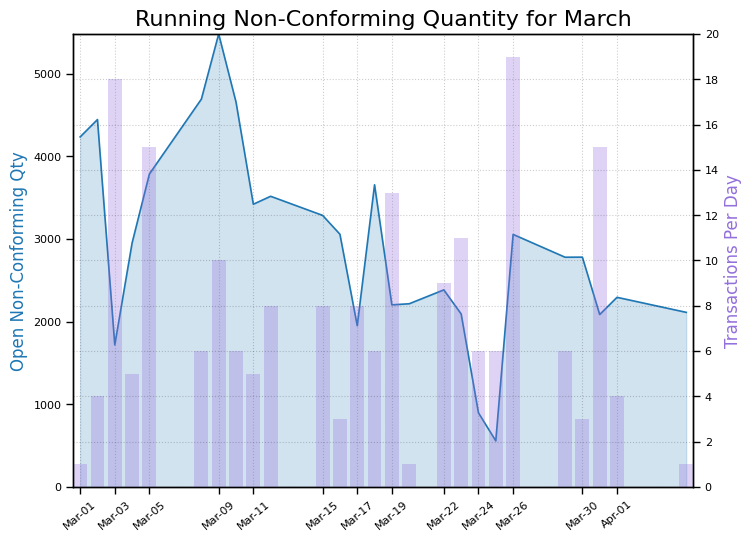

In [20]:
from sqlalchemy import create_engine, text
from datetime import datetime as dt
import numpy as np
from config import connectionString

# SQL Connection
con = create_engine(connectionString).connect()

# *** Change as Needed ***
# From Date (format in "'yyyy-mm-dd'")
from_date = "'2021-03-01'"

# Get the ongoing results from the last month into a single row
prevDFQuery = open("sql\LeadingMonth.sql").read().format(before=from_date)
prevDF = pd.read_sql(text(prevDFQuery), con)

prevDF = prevDF.drop(['CreateDate', 'JobNum'], axis=1)
prevDF = pd.DataFrame({'JobNum': 'LastMonth', 'DiscrepQty': prevDF['DiscrepQty'].sum(), 'CreateDate': np.datetime64('2021-03-01')}, index=[0])


# Get results from the current month
monthDFQuery = open("sql\MonthlyActivity.sql").read().format(before=from_date)
monthDF = pd.read_sql(text(monthDFQuery), con)
monthDF['CreateDate'] = pd.to_datetime(monthDF['CreateDate'])


# Concatenate our results and groupby on the date
totalDF = pd.concat([prevDF,monthDF], ignore_index=True)

totalDF['Transactions'] = np.zeros(len(totalDF.index))
totalDF = totalDF.groupby(by='CreateDate', as_index=False).agg({'DiscrepQty':'sum',
                                      'JobNum': 'max',
                                      'Transactions': 'count'})
totalDF['RunningSum'] = totalDF['DiscrepQty'].cumsum()

# Setup Figure
plt.figure(figsize=(8,6), dpi=100)
ax = plt.gca()
ax2 = ax.twinx()

# Plot time series and bar plot
ax.plot('CreateDate','RunningSum', data=totalDF, color='tab:blue')
ax2.bar('CreateDate', 'Transactions', data=totalDF, color='mediumpurple', alpha=.3)


xtick_labels = totalDF['CreateDate'].apply(lambda x: x.strftime("%b-%d")).tolist()


ax.tick_params(axis='x', labelrotation=40, labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
plt.xticks(ticks=totalDF['CreateDate'].tolist()[::2],labels=xtick_labels[::2], alpha=.7)

ax.margins(x=0,y=0, tight=True)

ytick_labels = ax2.get_yticks().tolist()
ax2.set_yticks((np.arange(min(ytick_labels), max(ytick_labels) +1))[::2])
ax.grid(axis='x', alpha=.2, color='k', ls=':', lw=.8)
plt.grid(axis='both', alpha=.2, color='k', ls=':',lw=.8)
ax.set_ylabel('Open Non-Conforming Qty', color='tab:blue', fontsize=12)
ax2.set_ylabel('Transactions Per Day', color='mediumpurple', fontsize=12)


ax.fill_between(x=totalDF.CreateDate.tolist(),y1=totalDF.RunningSum.tolist(),y2=0,alpha=0.2,color='tab:blue')

plt.title("Running Non-Conforming Quantity for March", fontsize=16)

con.close()
